In [ ]:
import os
import cv2
import pickle
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from skimage import exposure, restoration
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
DATA_PATH = 'RetinalOCT_Dataset/RetinalOCT_Dataset'

LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS
GABOR_THETAS = np.arange(0, np.pi, np.pi / 4)

SAVE_FEATURES = True

classes = ['AMD','CNV','CSR','DME','DR','DRUSEN','MH','NORMAL']

In [3]:
def load_image(split):
    images = []
    labels = []
    split_path = os.path.join(DATA_PATH, split)
    
    for i, folder in enumerate(os.listdir(split_path)):
        folder_path = os.path.join(split_path, folder)
        files = sorted(os.listdir(folder_path))
        for file in files:
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            images.append(img)
            labels.append(i)

    return np.array(images), np.array(labels)

In [4]:
def preprocess_oct(image):
    # 1. Denoising: bilateral filter lebih halus untuk struktur retina
    denoised = cv2.bilateralFilter(image, 9, 75, 75)
    
    # 2. Kontras lokal pakai CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Normalisasi z-score (lebih stabil dari min-max)
    norm = (enhanced - np.mean(enhanced)) / (np.std(enhanced) + 1e-8)
    
    return enhanced, norm


In [5]:
def extract_features(img):
    enhanced, norm = preprocess_oct(img)
    features = []
    enhanced_uint8 = enhanced.astype(np.uint8)

    # ---- Statistik dasar ----
    features.extend([
        np.mean(norm),
        np.std(norm),
        skew(norm.ravel()),
        kurtosis(norm.ravel()),
        np.percentile(norm, 10),
        np.percentile(norm, 50),
        np.percentile(norm, 90)
    ])

    # ---- Sobel & edge ----
    sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    features.extend([np.mean(grad_mag), np.std(grad_mag)])

    blurred = cv2.GaussianBlur(enhanced_uint8, (5, 5), 1)
    edges = cv2.Canny(blurred, 80, 200)
    edge_density = np.mean(edges > 0)
    features.append(edge_density)

    # ---- LBP ----
    lbp = local_binary_pattern(enhanced_uint8, LBP_POINTS, LBP_RADIUS, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=LBP_POINTS + 2, range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-8)
    features.extend(hist)

    # ---- GLCM (Gray-Level Co-Occurrence Matrix) ----
    glcm = graycomatrix(enhanced_uint8, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    props = ['contrast', 'correlation', 'energy', 'homogeneity']
    for p in props:
        features.extend(graycoprops(glcm, p).flatten())

    # ---- Gabor filter bank ----
    for theta in GABOR_THETAS:
        kernel = cv2.getGaborKernel((15, 15), 4.0, theta, 10.0, 0.5, 0)
        fimg = cv2.filter2D(enhanced_uint8, cv2.CV_32F, kernel)
        features.extend([np.mean(fimg), np.std(fimg)])

    return np.array(features)

In [6]:
def extract_features_batch(images):    
    features = []
    total = len(images)
    
    for i, img in enumerate(images, 1):
        feature = extract_features(img)
        features.append(feature)

        if i % (total//10) == 0:
            percentage = int((i / total) * 100)
            print(f"==> {percentage}% done ({i}/{total} images)\n")
    
    print("Features Extraction Completed\n")
    return np.vstack(features)

In [7]:
train_img_raw, Y_train = load_image('train')
val_img_raw, Y_val = load_image('val')
test_img_raw, Y_test = load_image('test')

X_train = extract_features_batch(train_img_raw)
X_val = extract_features_batch(val_img_raw)
X_test = extract_features_batch(test_img_raw)

==> 10% done (1840/18400 images)

==> 20% done (3680/18400 images)

==> 30% done (5520/18400 images)

==> 40% done (7360/18400 images)

==> 50% done (9200/18400 images)

==> 60% done (11040/18400 images)

==> 70% done (12880/18400 images)

==> 80% done (14720/18400 images)

==> 90% done (16560/18400 images)

==> 100% done (18400/18400 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==> 90% done (2520/2800 images)

==> 100% done (2800/2800 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==>

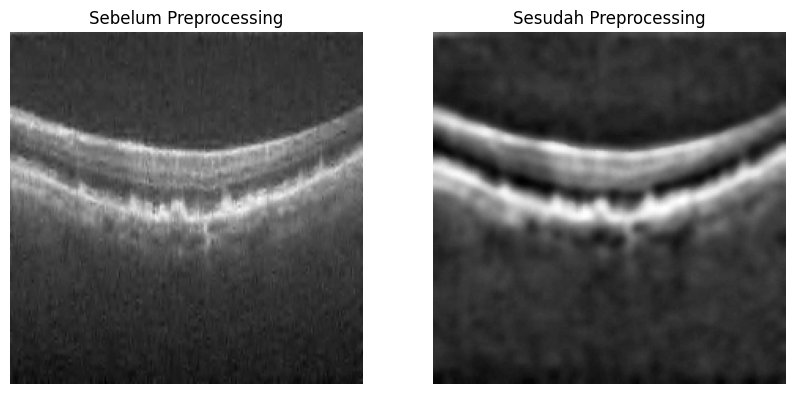

In [8]:
# 3. (Optional) visualization example
idx = min(49, len(train_img_raw) - 1)
original = train_img_raw[idx]
enhanced, _ = preprocess_oct(original)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Sebelum Preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced, cmap='gray')
plt.title('Sesudah Preprocessing')
plt.axis('off')

plt.show()

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# SVM

In [10]:
# di comment
svm = SVC(class_weight='balanced', random_state=42)

In [11]:
# di comment
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,               # 5-fold cross validation
    n_jobs=-1,          # gunakan semua core CPU
    verbose=2,
    scoring='accuracy'
)

grid_svm.fit(X_train_scaled, Y_train)
print("Best SVM: ", grid_svm.best_estimator_)
best_svm = grid_svm.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM:  SVC(C=100, class_weight='balanced', gamma=0.01, random_state=42)


In [12]:
with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)   

In [13]:
y_val_pred_svm = best_svm.predict(X_val_scaled)
y_test_pred_svm = best_svm.predict(X_test_scaled)

print("\nValidation Accuracy:", accuracy_score(Y_val, y_val_pred_svm))
print("Test Accuracy:", accuracy_score(Y_test, y_test_pred_svm))

print("\nClassification Report (Validation):")
print(classification_report(Y_val, y_val_pred_svm, target_names=classes))

print("\nClassification Report (Test):")
print(classification_report(Y_test, y_test_pred_svm, target_names=classes))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(Y_val, y_val_pred_svm))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(Y_test, y_test_pred_svm))


Validation Accuracy: 0.7464285714285714
Test Accuracy: 0.7375

Classification Report (Validation):
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.66      0.72      0.69       350
         CSR       0.89      0.94      0.91       350
         DME       0.66      0.57      0.61       350
          DR       0.84      0.82      0.83       350
      DRUSEN       0.50      0.52      0.51       350
          MH       0.82      0.79      0.81       350
      NORMAL       0.61      0.61      0.61       350

    accuracy                           0.75      2800
   macro avg       0.75      0.75      0.75      2800
weighted avg       0.75      0.75      0.75      2800


Classification Report (Test):
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.66      0.67      0.67       350
         CSR       0.90      0.93      0.91       350
 